In [1]:
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from collections import Counter
from typing import Dict, Any, Tuple, List, Callable, Optional
import gen_cloud

RES_DIR = "../res"
OUT_DIR = "../res/out"

In [2]:
views_list = gen_cloud.load_views(f"{RES_DIR}/scans/views.json", None)

# ensure that view rotation matrix is indeed a rotation matrix
det = np.linalg.det(np.array(views_list[90]["viewmat"])[:3, :3])

view = views_list[5]
list(view.keys()), det

(['name',
  'file_name',
  'depth_file_name',
  'semseg_file_name',
  'ins_file_name',
  'height',
  'width',
  'K',
  'fx',
  'fy',
  'cx',
  'cy',
  'viewmat',
  'orientation'],
 np.float64(1.0000002330740065))

In [3]:
depth_img, col_img = gen_cloud.load_rgbd(
    f"{RES_DIR}/scans/{view["depth_file_name"]}",
    f"{RES_DIR}/scans/{view["file_name"]}",
)
col_img.shape, depth_img.shape,

((720, 960, 3), (192, 256))

In [4]:
# key points that aid calibration for the visualization later
calibrate_points = np.array([[220., 400.], [290, 600], [600, 220], [630, 370], [410, 310], [615, 295]])
calibrate_points_depth = (calibrate_points / col_img.shape[:2] * depth_img.shape[:2] + 0.5).astype(np.int32)
calibrate_depths = depth_img[calibrate_points_depth[:, 1], calibrate_points_depth[:, 0]]
calibrate_depths

array([2.138, 2.302, 2.954, 3.114, 2.478, 3.014], dtype=float32)

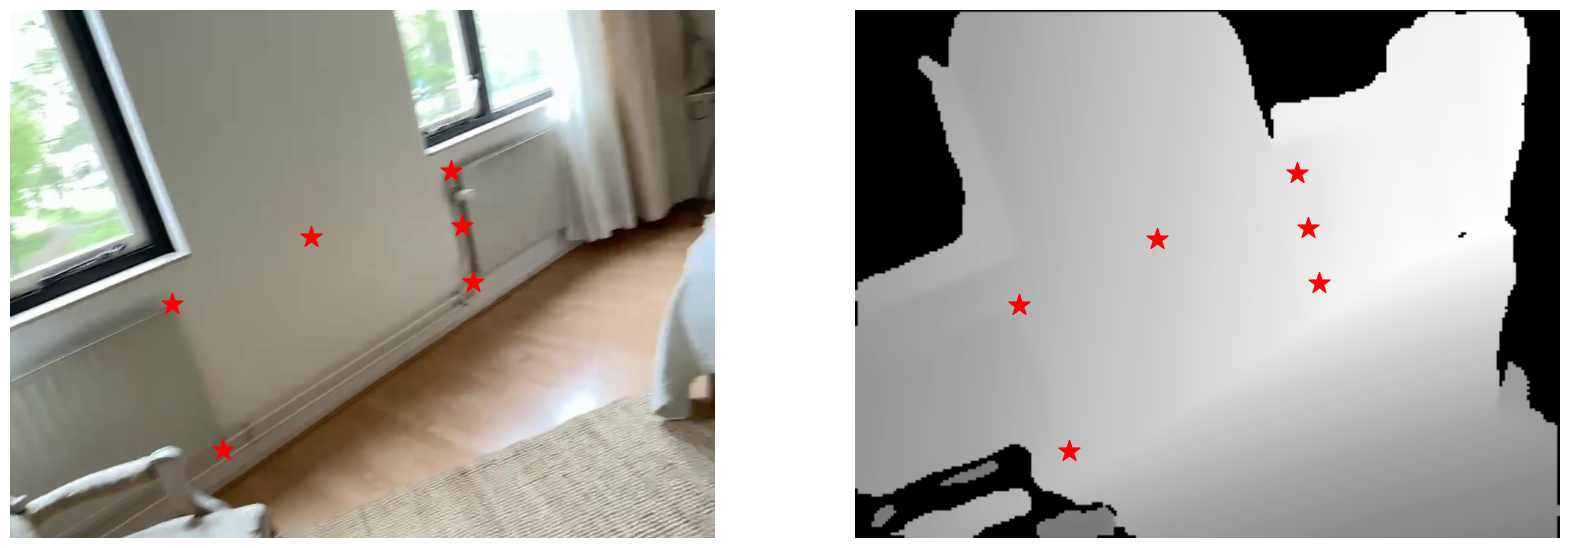

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(col_img)
ax[1].imshow(depth_img / depth_img.max(), cmap="Greys_r")

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].scatter(calibrate_points[:, 0], calibrate_points[:, 1], c="red", marker="*", s=250)
ax[1].scatter(calibrate_points_depth[:, 0], calibrate_points_depth[:, 1], c="red", marker="*", s=250)

plt.show()

In [6]:
# calibration points to 3D
calibrate_cloud, _ = gen_cloud.depth_to_points(
    calibrate_points, calibrate_depths, np.array(view["K"]), np.array(view["viewmat"])
)

In [7]:
SAMPLE_RATE = 10
ADD_RGB = False

views = views_list[:300:9]
#views = [views_list[0], views_list[20], views_list[40], views_list[50]] # TODO: remove

# load point cloud for views
cloud, uv_coords, num_samples = gen_cloud.views_info_to_points(
    views, f"{RES_DIR}/scans", SAMPLE_RATE,
    ADD_RGB
    
)
cloud.shape

(15260, 3)

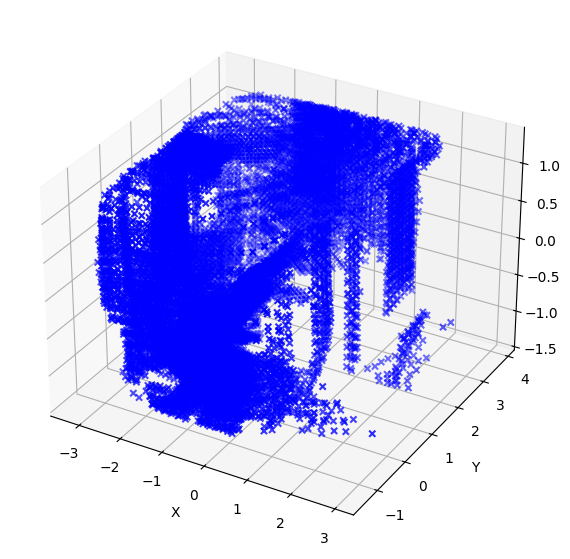

In [8]:
if ADD_RGB:
    # NOTE: is pretty slow
    c = [clrs.to_rgb(c) for c in cloud[:, 3:] / 255]
else:
    c = "blue"


fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(cloud[:, 2], cloud[:, 0], cloud[:, 1], c=c, marker="x")
img = ax.scatter(calibrate_cloud[:, 2], calibrate_cloud[:, 0], calibrate_cloud[:, 1], c="red", marker="x")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [13]:
"""
# TODO: do this during point cloud generation to save RAM?
Sparsify the point cloud by removing points that are too close to each other.
"""

# radius around a point in which there may be no other points
SPACE_PER_POINT = 0.1

# TODO: implement


WARNING clustering 5466 points to 1000 centroids: please provide at least 39000 training points


Clustering 5466 points in 3D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.12 s, search 0.04 s): objective=63.4731 imbalance=1.214 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.13 s, search 0.06 s): objective=55.1906 imbalance=1.190 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (0.15 s, search 0.06 s): objective=53.0533 imbalance=1.195 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (0.16 s, search 0.07 s): objective=54.6337 imbalance=1.175 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.18 s, search 0.08 s): objective=54.9411 imbalance=1.207 nsplit=0       


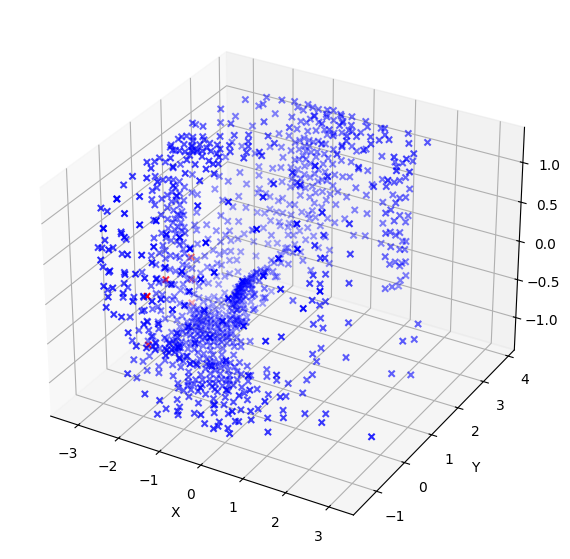

In [14]:
# TODO:
""" 
Filter method #1: K-means
"""
import faiss

cloud_means = faiss.Kmeans(
    d=3,
    k=1000,
    niter=20,
    nredo=5,
    verbose=True,
    gpu=False,
)

cloud_means.train(cloud)

new_cloud = cloud_means.centroids

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(new_cloud[:, 2], new_cloud[:, 0], new_cloud[:, 1], c="blue", marker="x")
img = ax.scatter(calibrate_cloud[:, 2], calibrate_cloud[:, 0], calibrate_cloud[:, 1], c="red", marker="x")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

After generating the point cloud, we can compute semantic embeddings for each point. First, each point is projected back to the corresponding image. Using SAM2, the object around the point is selected and using CLIP an embedding is generated.

In [15]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import clip
import cv2

# NOTE: for now, force cpu
# select the device for computation
if False and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"using device: {device}")

using device: cpu


/home/morris/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [16]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [17]:
CONFIG_DIR = "../../sam2/sam2/configs/sam2.1/sam2.1_hiera_t.yaml"
CHECKPOINT_DIR = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"

# load the SAM2 model
sam2_model = build_sam2(CONFIG_DIR, CHECKPOINT_DIR, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval();

In [18]:
# TODO: weg
def cut_out_mask(img: np.ndarray, mask: np.ndarray, out_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    Returns the cut-out image of the bounding box of the given mask.
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    r0, r1 = np.where(rows)[0][[0, -1]]
    c0, c1 = np.where(cols)[0][[0, -1]]

    out_img = img[r0:r1+1, c0:c1+1]
    if out_size is not None:
        return cv2.resize(out_img, out_size) # TODO: maybe first crop, then resize to minimize distortion
    return out_img

CUTOUT_SIZE = (224, 224) # TODO: param, base on clip model

PIL_img = Image.open(f"{RES_DIR}/scans/{views[0]['file_name']}")
img = np.array(PIL_img.convert("RGB"))

# encode image
sam2_predictor.set_image(img)

masks, _, _ = sam2_predictor.predict(
    point_coords=uv_coords[:5, np.newaxis, :],
    # label = 1 means we're looking for foreground objects
    point_labels=np.ones((5, 1)),
    # only return the most likely mask
    multimask_output=False,
)

In [19]:
# select objects
embeds = np.zeros((0, 512))
for mask in masks:
    object_cutout = cut_out_mask(col_img, mask[0], CUTOUT_SIZE)

    # compute clip embeddings
    clip_img = clip_preprocess(Image.fromarray(object_cutout)).unsqueeze(0).to(device)
    embeds = np.concatenate((embeds, clip_model.encode_image(clip_img).cpu().detach().numpy()), axis=0)

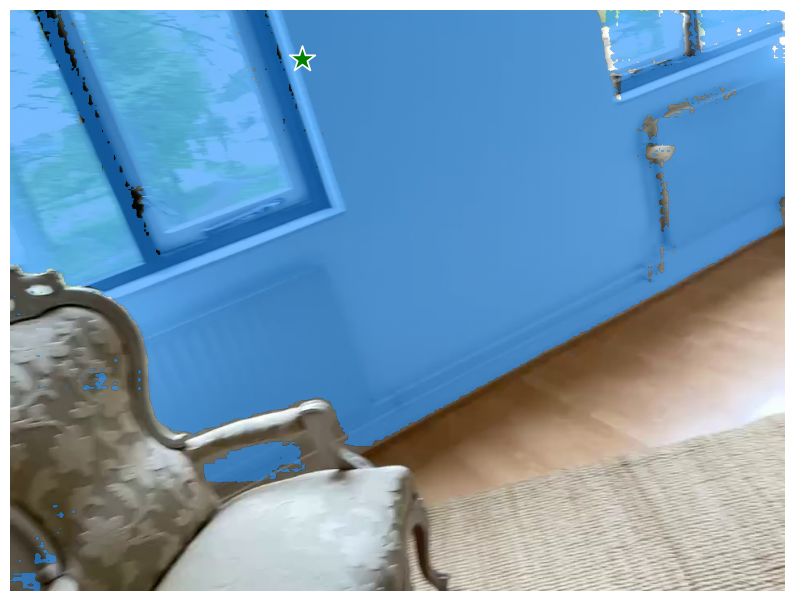

In [32]:
# NOTE: multiply with mask to purely get the mask, though only works well with larger SAM2 models,
#  because of messiness of the lower models
def cut_out_mask(img: np.ndarray, mask: np.ndarray, out_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    Returns the cut-out image of the bounding box of the given mask.
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    r0, r1 = np.where(rows)[0][[0, -1]]
    c0, c1 = np.where(cols)[0][[0, -1]]

    out_img = img[r0:r1+1, c0:c1+1]
    if out_size is not None:
        return cv2.resize(out_img, out_size) # TODO: maybe first crop, then resize to minimize distortion
    return out_img

# TODO: use torch consistently
def compute_semantics(
    col_img: np.ndarray,
    uv_coords: np.ndarray,

    sam2_model: SAM2ImagePredictor,
    clip_model: torch.nn.Module,
    clip_preprocess: Callable,
    device: torch.device,
) -> Tuple[torch.Tensor, np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the semantic embeddings for the objects in the image denoted by the uv-coordinates.
    More specifically, embeddings are computed using the SAM2 and CLIP model.

    # Note
    Assumes that SAM2 is set up with the given image beforehand.
        
    # Params
    * `col_img`: RGB image of shape [H x W x 3]
    * `uv_coords`: uv-coordinates in the image of shape [N x 2]
    * `sam2_model`: the SAM2 model
    * `clip_model`: the CLIP model
    
    # Returns
    * Semantic CLIP embeddings of shape [N x CLIP_DIM]
    * Binary masks of shape [N x 1 x H x W]
    * Scores of shape [N]
    """
    CUTOUT_SIZE = (224, 224) # TODO: param, base on clip model

    # predict masks
    masks, scores, _ = sam2_model.predict(
        point_coords=uv_coords[:, np.newaxis, :],
        # label = 1 means we're looking for foreground objects
        point_labels=np.ones((uv_coords.shape[0], 1)),
        # only return the most likely mask
        multimask_output=False,
    )

    # select object subimages
    clip_imgs = []
    for mask in masks:
        # select object, use ndim=4 to ensure consistent mask shapes
        object_cutout = cut_out_mask(col_img, np.array(mask, ndmin=4)[0], CUTOUT_SIZE)

        # compute clip embedding
        clip_imgs.append(clip_preprocess(Image.fromarray(object_cutout)).unsqueeze(0).to(device))

    # compute semantic embeddings
    with torch.inference_mode():
        clip_imgs = torch.concatenate(clip_imgs, dim=0).to(device)
        embeds = clip_model.encode_image(clip_imgs)
        
    return embeds, masks, scores

PIL_img = Image.open(f"{RES_DIR}/scans/{views[0]['file_name']}")
img = np.array(PIL_img.convert("RGB"))

sam2_predictor.set_image(img)
_, masks, scores = compute_semantics(
    img,
    uv_coords[:5],
    sam2_predictor,
    clip_model,
    clip_preprocess,
    device
)

show_masks(img, masks[0], scores[0], point_coords=uv_coords[np.newaxis, 0], input_labels=np.array([1]), borders=False)

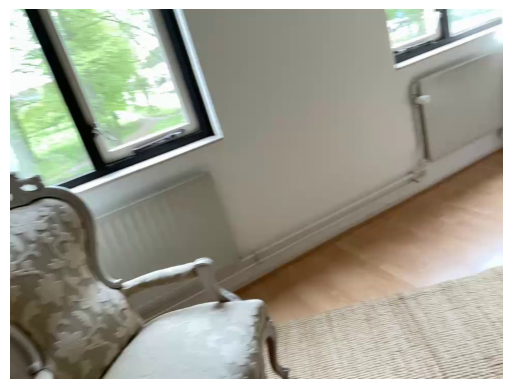

(torch.float32, torch.Size([1, 512]))

In [21]:
object_cutout = cut_out_mask(img, masks[0][0])

clip_img = clip_preprocess(PIL_img).unsqueeze(0).to(device)
semantic_embed = clip_model.encode_image(clip_img)

plt.imshow(object_cutout / 255.)
plt.axis("off")
plt.show()

semantic_embed.dtype, semantic_embed.shape

In [ ]:
BATCH_SIZE = 8

# select here to compute semantic embeddings; if False, then embeddings are set to 1s 
if True:
    # * compute semantics for point cloud *
    point_embeds = torch.zeros((0, 512)) # TODO: don't hardcode 512 and allocate fully at once

    # iterate over each view
    uv_coord_idx = 0
    for i, n in enumerate(num_samples):
        if n == 0:
            continue
        
        # load image
        img = Image.open(f"{RES_DIR}/scans/{views[i]['file_name']}")
        img = np.array(img.convert("RGB"))

        # encode image for segmentation
        sam2_predictor.set_image(img)

        # load semantics for all points corresponding to image
        for batch_start in range(0, n, BATCH_SIZE):
            # compute semantics for batch
            batch_size = min(BATCH_SIZE, n - batch_start)
            embeds, _, _ = compute_semantics(
                img,
                uv_coords[uv_coord_idx+batch_start : uv_coord_idx+batch_start+batch_size],
                sam2_predictor,
                clip_model,
                clip_preprocess,
                device
            )

            point_embeds = torch.concatenate((point_embeds, embeds), axis=0)

        uv_coord_idx += n

        print(f"View {i}: processed {uv_coord_idx} points total ({uv_coord_idx / len(uv_coords) * 100:.1f}%)")
else:
    point_embeds = torch.ones((len(cloud), 512)) # TODO: don't hardcode 512

point_embeds.shape

View 0: processed 142 points (2.6%)
View 1: processed 298 points (5.5%)
View 2: processed 455 points (8.3%)
View 3: processed 609 points (11.1%)
View 4: processed 779 points (14.3%)
View 5: processed 947 points (17.3%)
View 6: processed 1094 points (20.0%)
View 7: processed 1251 points (22.9%)
View 8: processed 1421 points (26.0%)
View 9: processed 1595 points (29.2%)
View 10: processed 1765 points (32.3%)
View 11: processed 1935 points (35.4%)
View 12: processed 2102 points (38.5%)


In [ ]:
render_points = {
    "cloud": [{
            "pos": point.tolist(),
            "embed": embed.tolist()
        } for point, embed in zip(cloud, point_embeds)
    ],

    "calibrate":[{
            "pos": point.tolist(),
        } for point in calibrate_cloud
    ],

    "views": [{
            # TODO: back to actually used views
            "pos": (-np.array(view["viewmat"])[:3, 3]).tolist(),
        } for view in views_list[:500]
    ]
}

# save point cloud for simulation re-use
json.dump(
    render_points,
    open(f"{OUT_DIR}/point_cloud.json", "w"),
)